In [1]:
import pandas as pd
import numpy as np
from modeling import Transfer_Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from tensorflow.keras.metrics import RootMeanSquaredError

# Variables from config file
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, C_SINGLE, C_GRID, C_COMMON
# enable autoreload
%load_ext autoreload
%autoreload 2

2022-07-05 22:56:37.844744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/devel/PCRE/8.41-GCCcore-7.3.0/lib:/opt/apps/software/lang/Perl/5.28.0-GCCcore-7.3.0/lib:/opt/apps/software/tools/expat/2.2.5-GCCcore-7.3.0/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib/python2.7/site-packages/numpy-1.14.5-py2.7-linux-x86_64.egg/numpy/core/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib64:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib:/opt/apps/software/math/GMP/6.1.2-GCCcore-7.3.0/lib:/opt/apps/software/devel/SQLite/3.24.0-GCCcore-7.3.0/lib:/opt/apps/software/lang/Tcl/8.6.8-GCCcore-7.3.0/lib:/opt/apps/software/lib/libreadline/7.0-GCCcore-7.3.0/lib:/opt/apps/software/devel/ncurses/6.1-GCCcore-7.3.0/lib:/opt/apps/software/tools/b

In [2]:
def assign_fold(df, n_folds = 5):
    df_n_data = df_nonfilled.groupby('skn').size().reset_index().rename(columns={0: "n_data"})
    df_n_data = df_n_data[df_n_data['n_data'] > 750]
    df = df.merge(df_n_data, left_on='skn', right_on='skn', how='inner')
    
    df_len_by_month = pd.DataFrame(df.groupby(by=['year', 'month']).size()).reset_index().rename({0: "len"}, axis=1)
    df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()
    n_samples_total = df_len_by_month['cumsum'].iloc[-1]
    n_samples_per_fold = np.ceil(n_samples_total / n_folds)
    
    df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)
    
    df_w_fold = pd.merge(left=df, right=df_len_by_month, left_on=['year', 'month'], right_on=['year', 'month'])
    
    return df_w_fold

In [67]:
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_GRID + C_COMMON)
df_filtered = assign_fold(df_nonfilled)

In [68]:
# model = Transfer_Model(inputs=C_SINGLE, outputs='data_in')
# model.set_model(
#     dict(
#         input_dim=len(C_SINGLE),
#         lr=0.001,
#         activation='elu',
#         n_units=512,
#         n_layers=2,
#         dropout=0.5
#     )
# )
# x_train, x_test, y_train, y_test = model.train_test_split(df_filtered, fold=1, fine_tune=False)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history_pretraining = model.model.fit(
#     x_train, y_train,
#     epochs=10,
#     verbose=True,
#     callbacks=[callback],
#     validation_split=0.2
# )

model = Transfer_Model(inputs=C_GRID, outputs='data_in')
model.set_model(
    dict(
        input_dim=len(C_GRID),
        lr=0.001, # doesn't really matter, because we will pass lr later again
        activation='elu',
        n_units=512,
        n_layers=2,
        dropout=0.5
    )
)

model.pre_train(
    df_filtered, fold=1, retrain_full=True,
    epochs=2000,
    batch_size=64,
    stopping_patience=10,
    lr=0.001,
    lr_factor=0.95,
    lr_patience=10,
    validation_split=0.2
)

Epoch 1/2000
185/185 - 1s - loss: 27.5144 - root_mean_squared_error: 5.2454 - val_loss: 27.2152 - val_root_mean_squared_error: 5.2168 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 2/2000
185/185 - 1s - loss: 26.0261 - root_mean_squared_error: 5.1016 - val_loss: 27.6210 - val_root_mean_squared_error: 5.2556 - lr: 0.0010 - 699ms/epoch - 4ms/step
Epoch 3/2000
185/185 - 1s - loss: 25.4511 - root_mean_squared_error: 5.0449 - val_loss: 26.0798 - val_root_mean_squared_error: 5.1068 - lr: 0.0010 - 764ms/epoch - 4ms/step
Epoch 4/2000
185/185 - 1s - loss: 25.3030 - root_mean_squared_error: 5.0302 - val_loss: 28.4671 - val_root_mean_squared_error: 5.3355 - lr: 0.0010 - 749ms/epoch - 4ms/step
Epoch 5/2000
185/185 - 1s - loss: 25.2261 - root_mean_squared_error: 5.0226 - val_loss: 26.2154 - val_root_mean_squared_error: 5.1201 - lr: 0.0010 - 816ms/epoch - 4ms/step
Epoch 6/2000
185/185 - 1s - loss: 24.9344 - root_mean_squared_error: 4.9934 - val_loss: 26.0234 - val_root_mean_squared_error: 5.1013 - lr: 0.0

In [69]:
model.save_pretrained_model('models/testing.hdf5')

<hr>

In [73]:
df_filtered['skn'].unique()

array([  54. ,   79. ,  250. ,  267. ,  296.1,  311. ,  338. ,  396. ,
        400. ,  406. ,  410. ,  485. ,  703. ,  718. ,  770. ,  783. ,
        784. ,  965. , 1075. , 1117. , 1134. ,   87. ,  702.7, 1020.1])

In [77]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
skn = 250
model.fine_tune(
    df_filtered, fold=1, skn=skn, retrain_full=True, model_path='models/testing.hdf5',
    epochs=300,
    batch_size=64,
    stopping_patience=10,
    lr=0.0001,
    lr_factor=0.95,
    lr_patience=8,
    verbose=2,
    validation_split=0.1
)

Epoch 1/300
9/9 - 0s - loss: 5.1663 - root_mean_squared_error: 2.2729 - val_loss: 2.2966 - val_root_mean_squared_error: 1.5154 - lr: 1.0000e-04 - 424ms/epoch - 47ms/step
Epoch 2/300
9/9 - 0s - loss: 5.1568 - root_mean_squared_error: 2.2709 - val_loss: 2.2761 - val_root_mean_squared_error: 1.5087 - lr: 1.0000e-04 - 60ms/epoch - 7ms/step
Epoch 3/300
9/9 - 0s - loss: 4.9067 - root_mean_squared_error: 2.2151 - val_loss: 2.5118 - val_root_mean_squared_error: 1.5849 - lr: 1.0000e-04 - 54ms/epoch - 6ms/step
Epoch 4/300
9/9 - 0s - loss: 4.7880 - root_mean_squared_error: 2.1882 - val_loss: 2.3357 - val_root_mean_squared_error: 1.5283 - lr: 1.0000e-04 - 52ms/epoch - 6ms/step
Epoch 5/300
9/9 - 0s - loss: 5.0358 - root_mean_squared_error: 2.2441 - val_loss: 2.2726 - val_root_mean_squared_error: 1.5075 - lr: 1.0000e-04 - 57ms/epoch - 6ms/step
Epoch 6/300
9/9 - 0s - loss: 4.5818 - root_mean_squared_error: 2.1405 - val_loss: 2.3156 - val_root_mean_squared_error: 1.5217 - lr: 1.0000e-04 - 51ms/epoch -

In [78]:
_,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

yhat_nn = model.model.predict(x_test_station)
rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
# rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(x_train_station, y_train_station)
yhat_linear_regression = linear_regression.predict(x_test_station)
rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
# rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Fold 1
 LR: 2.1952727620, NN: 2.0669175672


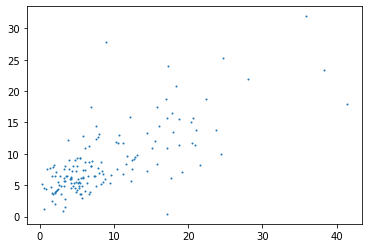

In [60]:
import matplotlib.pyplot as plt
plt.scatter(y_test_station, yhat_nn, s=1)

In [27]:
# model.load_pretrained_model('models/testing.hdf5')

In [24]:
# skn = 79
# model.load_model('models/testing.hdf5')
# x_train, y_train, x_test, y_test, x_train_station, x_test_station, y_train_station, y_test_station = \
# model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=79)
# model.model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.000005),
#     loss='mse',
#     metrics=[RootMeanSquaredError()]
# )
# callback_finetune = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [25]:
# history_finetune = model.model.fit(x_train_station, y_train_station, epochs=500, verbose=2, callbacks=[callback_finetune], validation_split=0.2)

Epoch 1/500
16/16 - 0s - loss: 24.6912 - root_mean_squared_error: 4.9690 - val_loss: 23.6069 - val_root_mean_squared_error: 4.8587 - 441ms/epoch - 28ms/step
Epoch 2/500
16/16 - 0s - loss: 24.5958 - root_mean_squared_error: 4.9594 - val_loss: 23.6064 - val_root_mean_squared_error: 4.8586 - 73ms/epoch - 5ms/step
Epoch 3/500
16/16 - 0s - loss: 25.2892 - root_mean_squared_error: 5.0288 - val_loss: 23.6032 - val_root_mean_squared_error: 4.8583 - 73ms/epoch - 5ms/step
Epoch 4/500
16/16 - 0s - loss: 24.3468 - root_mean_squared_error: 4.9343 - val_loss: 23.6058 - val_root_mean_squared_error: 4.8586 - 73ms/epoch - 5ms/step
Epoch 5/500
16/16 - 0s - loss: 24.1347 - root_mean_squared_error: 4.9127 - val_loss: 23.5963 - val_root_mean_squared_error: 4.8576 - 75ms/epoch - 5ms/step
Epoch 6/500
16/16 - 0s - loss: 24.5623 - root_mean_squared_error: 4.9560 - val_loss: 23.5912 - val_root_mean_squared_error: 4.8571 - 74ms/epoch - 5ms/step
Epoch 7/500
16/16 - 0s - loss: 24.2972 - root_mean_squared_error: 4.

In [11]:
# yhat_station = model.model.predict(x_test_station)
# rmse_nn = mean_squared_error(y_test_station, yhat_station, squared=False)
# # rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

# # Linear Regression
# linear_regression = LinearRegression()
# linear_regression.fit(x_train_station, y_train_station)
# yhat_linear_regression = linear_regression.predict(x_test_station)
# rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
# # rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

# print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

NameError: name 'x_test_station' is not defined